UFRJ/EQ, Agosto de 2018,
(updated @ 19 de Junho de 2019).

# Evaporador / Compressor, Equação de estado cúbica

iuri segtovich

In [1]:
import numpy as np
#1. arrays (vetores R^n) para cálculos em sequência
#2. resolução de raiz de polinômios (np.roots)

from matplotlib import pyplot as plt
# pacote para desenhar gráficos

from scipy import optimize as opt
# resolução de equação não linear por método de biseção (opt.bisect)

In [2]:
R=8.314 #S.I.

In [3]:
# Cúbica
def func_P_cubic(T,Vm):
    a=func_a(T=T)
    return R*T/(Vm-b) - a/(Vm**2 + u*b*Vm + w*b**2)


def func_a(T):
    Tr=T/Tc
    return ac*(1+f_omega*(1-Tr**(.5)))**2

In [4]:
def func_VL_VV_cubic(T,P):
    a=func_a(T=T)
    A=a*P/(R**2*T**2)
    B=b*P/(R*T)
    
    c3=1 
    c2=-(1+B-u*B)
    c1=(A+w*B**2-u*B-u*B**2)
    c0=-A*B-w*B**2-w*B**3
    
    list_coeffs=[c3,c2,c1,c0]

    Z1,Z2,Z3=np.roots(list_coeffs) #Como c3=1, nunca vai vir menos de três raízes (incluindo real e complexa)
    
    V1=Z1*R*T/P
    V2=Z2*R*T/P
    V3=Z3*R*T/P
        
    imag_tol = 1e-11

    listVphysical=[]
    
    for V in [V1,V2,V3]:
        if (abs(V.imag) < imag_tol) and (V.real > b): #condicao para existencia de um valor real
            listVphysical.append(V.real)
    nVphysical = len(listVphysical)
    vL=min(listVphysical) #se shouver apenas um V físico a função vai retornar valores de Volume iguais para liq e vap
    vV=max(listVphysical) 
    
    return vL, vV, nVphysical

In [5]:
def func_Plimits(T):
    #cálculo dos limites para busca de pressão de saturação
    
    #calcular coeficientes da representação polinomial
    a=func_a(T=T)
    
    c4 = 1
    c3 = (-2*R*T*b*u + 2*a)/(-R*T)
    c2 = (-R*T*b**2*u**2 - 2*R*T*b**2*w + a*b*u - 4*a*b)/(-R*T)
    c1 = (-2*R*T*b**3*u*w - 2*a*b**2*u + 2*a*b**2)/(-R*T)
    c0 = (-R*T*b**4*w**2 + a*b**3*u)/(-R*T)
    
    #resolver raízes com a função roots
    list_coeffs=[c4,c3,c2,c1,c0]

    V1,V2,V3,V4=np.roots(list_coeffs) #Como c4=1, nunca vai vir menos de quatro raízes (incluindo real e complexa)
    
    imag_tol = 1e-11

    listVphysical=[]
    
    for V in [V1,V2,V3,V4]:
        if (abs(V.imag) < imag_tol) and (V.real > b): #condicao para existencia de um valor real
            listVphysical.append(V.real)
    nVphysical = len(listVphysical)
    
    if nVphysical >= 1:
        Vinfi = min(listVphysical)
        Vsupi = max(listVphysical)
    
    
        #calcular a pressão correspondente a cada raiz de volume selecionada
        Psupi = func_P_cubic(T=T,Vm=Vsupi)
        Pinfi = func_P_cubic(T=T,Vm=Vinfi)
            
    elif nVphysical==0:
        #não achamos faixa de busca
        Vli=None
        Vvi=None
        Psupi=None
        Pinfi=None
        
    return Vinfi,Vsupi,Pinfi,Psupi,nVphysical

In [6]:
def func_Gres_RT(T,P,Z):    
    a=func_a(T)
    A=a*P/(R**2*T**2)
    B=b*P/(R*T)
    T1=A/(B*(u**2-4*w)**.5)
    T2=(-1)
    T3=2*Z+B*(u+(u**2-4*w)**.5)
    T4=2*Z+B*(u-(u**2-4*w)**.5)
    Gres_RT_TPZ = (Z-1)-np.log(Z-B)+T1*T2*np.log(T3/T4)
    return Gres_RT_TPZ

In [7]:
def func_Psat(T):
    
    def func_RES(P):
        VL,VV,nV=func_VL_VV_cubic(T=T,P=P)
        ZL=VL*P/(R*T)
        ZV=VV*P/(R*T)
        Gres_RT_L=func_Gres_RT(T=T,P=P,Z=ZL)
        Gres_RT_V=func_Gres_RT(T=T,P=P,Z=ZV)
        return Gres_RT_L-Gres_RT_V

    Vinfi,Vsupi,Pinfi,Psupi,nlim=func_Plimits(T=T)
    
    #definir com limite superior uma pressão ligeiramente abaixo da pressão limite superior
    #e ligeiramente acima da pressão limite inferior para garantir que existam três volumes nas condições teste
    #não levar pressão negativa para o cálculo de pressão de saturação
    Psupi=Psupi*.999999

    if Pinfi > 0.:
        Pinfi = Pinfi*1.000001
    else:
        Pinfi = Psupi/1e10
    
    P0a=Pinfi
    P0b=Psupi
    
    Psati = opt.bisect(func_RES,P0a,P0b)
    
    return Psati

In [8]:
def func_Tsat(P):
    
    def func_RES(T):
        return func_Psat(T=T)-P

    Tsati = opt.fsolve(func_RES,.99*Tc)[0]
    
    return Tsati

In [9]:
def func_Hgi(T): #integral CpdT, considerando como temperatura de referência 298K
    T0 = 298.
    Hgi = R * (A1 * (T - T0) + (B1 / 2) * (T ** 2 - T0 ** 2) + (C1 / 3) * (T ** 3 - T0 ** 3) + (D1) * (
                    T ** (-1) - T0 ** (-1)))
    return Hgi

#calculo de Hreal considerando como temperatura de referência 298K
def func_Hreal(T,P,Z):
    Hres=func_Hres(T=T,P=P,Z=Z)
    Hgi=func_Hgi(T=T)
    return Hres+Hgi

def func_dadT(T): #definição de da/dT
    Tr = T/Tc
    dadT = (-0.45724*(R*Tc)**2/Pc)*f_omega*((1+f_omega*(1-Tr**.5))**2/(Tc*T))**.5  
    return dadT

def func_Hres(T,P,Z): #definição de Hres (A=U-TS; H=U+PV :. H=A+PV+TS)
    B=(b*P)/(R*T)
    a=func_a(T=T)
    dadT=func_dadT(T=T)    
    T1=np.sqrt(u**2-4*w)    
    Hres = ((a-T*dadT)/(b*T1))*np.log( (2*Z+B*(u-T1))/(2*Z+B*(u+T1)) ) + R*T*(Z-1)
    return Hres

In [10]:
def func_Sres(T,P,Z): #cálculo da S residual
    B=b*P/(R*T)
    dadT=func_dadT(T=T)
    T1=np.sqrt(u**2-4*w)
    Sres = R*np.log(Z-B) - (dadT/(b*T1))*np.log( (2*Z+B*(u-T1))/(2*Z+B*(u+T1)) )
    return Sres

def func_Sgi(T,P): #cálculo da S gas ideal usando integral Cp/T dT e ln(P/P0)
    #considerando como temperatura de referência 298K e pressao de referencia 1 bar
    T0=298. #K
    P0=1e5 #Pa
    Sgi = R * (A1 * np.log(T / T0) + B1 * (T - T0) + (C1 / 2) * (T ** 2 - T0 ** 2) - (D1 / 2) * (
                T ** (-2) - T0 ** (-2))) - R * np.log(P / P0)
    return Sgi

def func_Sreal(T,P,Z):
    #considerando como temperatura de referência 298K e pressao de referencia 1 bar
    Sgi = func_Sgi(T=T,P=P)
    Sres = func_Sres(T=T,P=P,Z=Z)
    Sreal = Sres+Sgi
    return Sreal

In [11]:
#Cálculo de T através de Van der Waals
from scipy.optimize import fsolve

  
def func_T_cubic(P,Vm):
    from scipy.optimize import fsolve
    
    def T_guess(P,Vm):
        a=func_a(T=Tc)
        return (P + a/(Vm**2 + u*b*Vm + w*b**2) )*(Vm-b)/R

    def RES(T):
        return P-func_P_cubic(T=T,Vm=Vm)

    T=fsolve(func=RES,x0=T_guess(P=P,Vm=max(Vm,b*1.01)))[0]

    return T

# Resolução

# Água

In [12]:
Tc= 647.1 #K
Pc= 220.55e5 #Pa
omega= 0.345 #fator acêntrico, adimensional

#Cp
A1 = 3.470
B1 = 1.450E-3
C1 = 0
D1 = 0.121E5

# Soave

In [13]:
u=1
w=0

b=(0.08664*R*Tc)/Pc
ac=0.42748*R**2*Tc**2/Pc

f_omega = 0.48 + 1.574*omega-0.176*omega**2

In [14]:
T1=298
P1=1e5
M1=100

PSAT1=func_Psat(T=T1)
print(P1,PSAT1)
#P1>PSAT1 :. CORRENTE 1 É LÍQUIDO

VL1,VV1,n1=func_VL_VV_cubic(T=T1,P=P1)
V1=VL1
print(V1)
#VOLUME 1 = VOLUME DE LÍQUIDO

Z1=P1*V1/(R*T1) #NÃO ESQUECER ESSE PARÊNTESES
print(Z1)

H1=func_Hreal(T=T1,P=P1,Z=Z1)
print(H1)

S1=func_Sreal(T=T1,P=P1,Z=Z1)
print(S1)

P2=P1
print(P2)
#processo isobarico no evaporador

T2=func_Tsat(P=P2)
print(T2)
#dado vapor saturado após o evaporador

VL2,VV2,n2=func_VL_VV_cubic(T=T2,P=P2)
V2=VV2
print(V2)
#VOLUME 2 = VOLUME DE vapor

Z2=P2*V2/(R*T2)
print(Z2)

H2=func_Hreal(T=T2,P=P2,Z=Z2)
print(H2)

S2=func_Sreal(T=T2,P=P2,Z=Z2)
print(S2)

DH21=H2-H1
print(DH21)
DS21=S2-S1
print(DS21)

Q=M1*DH21
print(Q)

P3=1e6
S3=S2

def RES(T3):
    VL3,VV3,n3=func_VL_VV_cubic(T=T3,P=P3)
    Z3=P3*VV3/(R*T3)
    return func_Sreal(T=T3,P=P3,Z=Z3)-S3


T3 = opt.fsolve(RES,T2)[0]
print(T3)

VL3,VV3,n3=func_VL_VV_cubic(T=T3,P=P3)
V3=VV3
Z3=P3*V3/(R*T3)
H3=func_Hreal(T=T3,P=P3,Z=Z3)
print(H3)

DH32=H3-H2
DS32=S3-S2
W=M1*DH32

100000.0 2320.3421011955475
2.38440718022e-05
0.000962396725595
-48120.4198976
-130.193447862
100000.0
375.28437635
0.030944366075
0.991770270266
2401.92097576
7.67017182151
50522.3408733
137.863619683
5052234.08733
649.297169493
11656.907864


# Gráficos (extra)

## envelope

In [15]:
Ttest=T1
nV=100
minV=b*1.01
maxV=1e-1
seqVm= np.logspace(np.log10(minV),np.log10(maxV),nV)

seqPt1=np.zeros(nV)
seqPt2=np.zeros(nV)
seqPt3=np.zeros(nV)
for i in range(nV):
    seqPt1[i]=func_P_cubic(T=T1,Vm=seqVm[i])
    seqPt2[i]=func_P_cubic(T=T2,Vm=seqVm[i])
    seqPt3[i]=func_P_cubic(T=T3,Vm=seqVm[i])

nPsat=100
seqT3=np.linspace(Tc/3,Tc*.99,nPsat)
seqP3=np.zeros(nPsat)
for i in range(nPsat):
    seqP3[i]=func_Psat(seqT3[i])

VL_seq=np.zeros(nPsat)
VV_seq=np.zeros(nPsat)
nV_seq=np.zeros(nPsat)
for i in range(nPsat):
    VL_seq[i],VV_seq[i],nV_seq[i]=func_VL_VV_cubic(T=seqT3[i],P=seqP3[i])
    
Psat_test = func_Psat(T=Ttest)


In [16]:
vl,vv,n = func_VL_VV_cubic(T=Tc,P=Pc)
print(vl,vv,n)
vc=vv

7.9821967968e-05 7.9821967968e-05 1


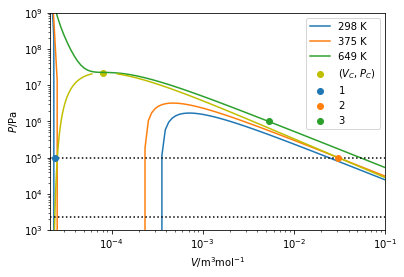

In [17]:
plt.plot(seqVm,seqPt1,label='{0:.0f}'.format(T1)+' K') #create a logarithm vs logarithm scale plot of pressure vs volume, using the function pressure in each value of the volume list
plt.plot(seqVm,seqPt2,label='{0:.0f}'.format(T2)+' K') #create a logarithm vs logarithm scale plot of pressure vs volume, using the function pressure in each value of the volume list
plt.plot(seqVm,seqPt3,label='{0:.0f}'.format(T3)+' K') #create a logarithm vs logarithm scale plot of pressure vs volume, using the function pressure in each value of the volume list
plt.ylabel(r'$P / \mathrm{Pa}$') #create labels to be displayed in y axis of the plot
plt.xlabel(r'${V} / \mathrm{m^{3}mol^{-1}}$') #use matplotlib's  mathtext to create special symbols in the x label
plt.ylim(1e3,1e9)#define max and min limits of the y axis only to the positive pressure range. remember that this plot is in logarithm scale and it does not accept negative values.
plt.xlim(b,1e-1) #define max and min limits of the x axis
plt.xscale('log')
plt.yscale('log')

plt.plot(VL_seq,seqP3, color='y')
plt.plot(VV_seq,seqP3, color='y')


plt.axhline(func_Psat(T1),color='black',ls=':')
plt.axhline(func_Psat(T2),color='black',ls=':')

plt.scatter(vc,Pc,color='y',label=r'$(V_{C},P_{C})$')

plt.scatter(V1,P1,label='1',zorder=10)
plt.scatter(V2,P2,label='2',zorder=10)
plt.scatter(V3,P3,label='3',zorder=10)

plt.legend()



plt.show()

# diagrama de fases no envelope P versus H

In [18]:
#CALCULAR H PARA CADA TSAT/PSAT/VSATL E TSAT/PSAT/VSATV

HL_seq=np.zeros(nPsat)
HV_seq=np.zeros(nPsat)
for i in range(nPsat):
    VL,VV,nV=func_VL_VV_cubic(T=seqT3[i],P=seqP3[i])
    ZL=seqP3[i]*VL/(R*seqT3[i])
    ZV=seqP3[i]*VV/(R*seqT3[i])
    HL_seq[i]=func_Hreal(T=seqT3[i],P=seqP3[i],Z=ZL)
    HV_seq[i]=func_Hreal(T=seqT3[i],P=seqP3[i],Z=ZV)

In [19]:
Ttest=T1

#CALCULAR H PARA seqV DADO T
nV=10000
seq_V= np.logspace(np.log10(b*1.11),6+np.log10(R*Tc/Pc),nV)
seq_P=np.zeros(nV)
seq_H=np.zeros(nV)
Z=np.zeros(nV)
for i in range(nV):
    seq_P[i]= func_P_cubic(Ttest,seq_V[i])
    Z[i]=(seq_P[i]*seq_V[i])/(R*Ttest)
    seq_H[i]=func_Hreal(T=Ttest,P=seq_P[i],Z=Z[i])
    
Ttest=T2

#CALCULAR H PARA seqV DADO T
seq_P2=np.zeros(nV)
seq_H2=np.zeros(nV)
for i in range(nV):
    seq_P2[i]= func_P_cubic(Ttest,seq_V[i])
    Z[i]=(seq_P2[i]*seq_V[i])/(R*Ttest)
    seq_H2[i]=func_Hreal(T=Ttest,P=seq_P2[i],Z=Z[i])
    
Ttest=T3

#CALCULAR H PARA seqV DADO T
seq_P3=np.zeros(nV)
seq_H3=np.zeros(nV)
for i in range(nV):
    seq_P3[i]= func_P_cubic(Ttest,seq_V[i])
    Z[i]=(seq_P3[i]*seq_V[i])/(R*Ttest)
    seq_H3[i]=func_Hreal(T=Ttest,P=seq_P3[i],Z=Z[i])    

In [20]:
Hrealc=func_Hreal(T=Tc,P=Pc,Z=Pc*vc/(R*Tc))

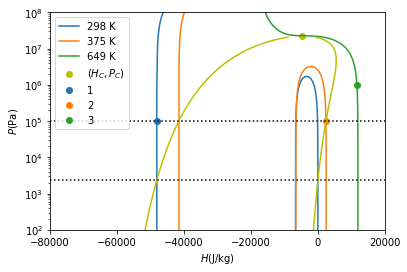

In [21]:
plt.plot(seq_H,seq_P,label='{0:.0f}'.format(T1)+' K')
plt.plot(seq_H2,seq_P2,label='{0:.0f}'.format(T2)+' K')
plt.plot(seq_H3,seq_P3,label='{0:.0f}'.format(T3)+' K')
plt.yscale('log')
plt.ylabel(r'$P (\mathrm{Pa})$')
plt.xlabel(r'${H} (\mathrm{J/Kg)}})$')

plt.plot(HL_seq,seqP3, color='y')
plt.plot(HV_seq,seqP3, color='y')
plt.yscale('log')
plt.ylabel(r'$P (\mathrm{Pa})$')
plt.xlabel(r'${H} (\mathrm{J/kg})$')
plt.xlim(-80000,20000)
plt.ylim(1e2,1e8)

plt.scatter(Hrealc,Pc, color='y',label=r'$(H_{C},P_{C})$')
plt.axhline(Psat_test,color='black',ls=':')
plt.axhline(P2,color='black',ls=':')


plt.scatter(H1,P1,label='1')
plt.scatter(H2,P2,label='2')
plt.scatter(H3,P3,label='3')

plt.legend()

plt.show()

In [22]:
# envelope
#CALCULAR S PARA CADA TSAT/PSAT/VSATL E TSAT/PSAT/VSATV
SL_seq=np.zeros(nPsat)
SV_seq=np.zeros(nPsat)
for i in range(nPsat):
    VL,VV,nV=func_VL_VV_cubic(T=seqT3[i],P=seqP3[i])
    ZL=seqP3[i]*VL/(R*seqT3[i])
    ZV=seqP3[i]*VV/(R*seqT3[i])
    SL_seq[i]=func_Sreal(T=seqT3[i],P=seqP3[i],Z=ZL)
    SV_seq[i]=func_Sreal(T=seqT3[i],P=seqP3[i],Z=ZV)
    


In [23]:
# isobaras

Ptest=P1
nV=1000


seq_T=np.zeros(nV)
seq_S=np.zeros(nV)
Z=np.zeros(nV)

seq_V= np.logspace(np.log10(b*1.11),4+np.log10(R*Tc/Pc),nV)

for i in range(nV): #para cada volume terá um valor de T e um de S
    seq_T[i]= func_T_cubic(P=Ptest,Vm=seq_V[i])
    Z[i]=(Ptest*seq_V[i])/(R*seq_T[i])
    seq_S[i]=func_Sreal(T=seq_T[i],P=Ptest,Z=Z[i])
    
# isobaras

Ptest=P3

seq_T2=np.zeros(nV)
seq_S2=np.zeros(nV)

for i in range(nV): #para cada volume terá um valor de T e um de S
    seq_T2[i]= func_T_cubic(P=Ptest,Vm=seq_V[i])
    Z[i]=(Ptest*seq_V[i])/(R*seq_T2[i])
    seq_S2[i]=func_Sreal(T=seq_T2[i],P=Ptest,Z=Z[i])

In [24]:
Srealc=func_Sreal(T=Tc,P=Pc,Z=Pc*vc/(R*Tc))

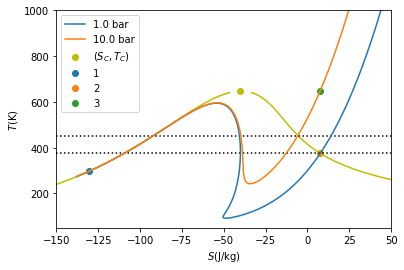

In [25]:
plt.plot(SL_seq,seqT3, color='y')
plt.plot(SV_seq,seqT3, color='y')


plt.ylabel(r'$T (\mathrm{K})$') 
plt.xlabel(r'${S} (\mathrm{J/kg})$')
plt.xlim(-150,50)
plt.ylim(50,1000)
plt.scatter(Srealc,Tc, color='y',label=r'$(S_{C},T_{C})$')
plt.axhline(func_Tsat(P=P1),color='black',ls=':')
plt.axhline(func_Tsat(P=P3),color='black',ls=':')
#isobara
plt.plot(seq_S,seq_T,label='{0:.1f}'.format(P1/1e5)+' bar')    
plt.plot(seq_S2,seq_T2,label='{0:.1f}'.format(P3/1e5)+' bar')    

plt.scatter(S1,T1,label='1')
plt.scatter(S2,T2,label='2')
plt.scatter(S3,T3,label='3')

plt.legend()
plt.show()


# Referências

>* Reid, R. C., Prausnitz, J. M. and Poling, B. E., 1987. The Properties of Gases and Liquids. 4th ed., McGraw-Hill. [ISBN: 0070517991, 9780070517998
](https://books.google.com.br/books?id=AcRTAAAAMAAJ)

>* Smith, J. M., van Ness, H. C. and Abbott, M. M., 2007. Introdução a termodinâmica da engenharia química. 7a ed., LTC. [ISBN: 8521615531, 9788521615538](https://books.google.com.br/books?id=TzeQPgAACAAJ)


>* Topliss, R J., Dimitrelis D., and Prausnitz, J. M., 1988, “Computational Aspects of a Non-Cubic Equation of State for Phase-Equilibrium Calculations. Effect of Density-Dependent Mixing Rules.” Computers & Chemical Engineering 12 (5): 483–89. [doi:10.1016/0098-1354(88)85067-1](http://dx.doi.org/10.1016/0098-1354(88)85067-1)

>* [numpy.roots ](https://docs.scipy.org/doc/numpy/reference/generated/numpy.roots.html)
>* [scipy.optimize.bisect](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.bisect.html)
>* [scipy.optimize.fsolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html)